# Data assimilation in neXtSIM-DG with NEDAS


## Environment and configuration

In [1]:
import sys
import os
notebook_root = '/home/nextsim-workshop/notebooks-nextsim-workshop2025'
data_root = '/home/nextsim-workshop/data-nextsim-workshop2025'

# temporary solution...will use installed package once develop is merged
sys.path.append(os.path.join(data_root, 'assimilation', 'NEDAS'))

# suppress cache warning
os.environ["UCX_LOG_LEVEL"] = "error"

In [24]:
import numpy as np
from datetime import datetime, timedelta, timezone

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean

##for display of plots with sliders
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

In [3]:
# check how many CPUs are available on your system
os.cpu_count()

8

In [4]:
# Configuration
from NEDAS.config import Config

config_file = os.path.join(notebook_root, 'assimilation', 'config.yml')

c = Config(config_file=config_file,
           nproc=6, ## number of processors; set according to your cpu count
           nens=6,  ## ensemble size
           debug=False,
          )

In [5]:
ncycle = int((c.time_end - c.time_start) / (c.cycle_period*timedelta(hours=1)))


In [6]:
model = c.models['nextsim.dg']

model

In [7]:
# Analysis scheme: offline filter
from NEDAS.schemes import get_analysis_scheme

scheme = get_analysis_scheme(c)

scheme

## Truth run

In [20]:
run_dir = os.path.join(model.truth_dir, 'run', 'ens_01')
os.system("mkdir -p "+run_dir)

icbc_dir = os.path.join(data_root, 'assimilation', 'icbc')
init_file = os.path.join(icbc_dir, f"restart{c.time_start:%Y-%m-%dT%H:%M:%SZ}.nc")
atmos_forcing_file = os.path.join(icbc_dir, "25km_NH.ERA5.nc")
ocean_forcing_file = os.path.join(icbc_dir, "25km_NH.TOPAZ4.nc")
for file in [init_file, atmos_forcing_file, ocean_forcing_file]:
    os.system(f"ln -fs {file} {run_dir}/.")

c.time = c.time_start
while c.time < c.time_end:
    file = f"restart{c.time:%Y-%m-%dT%H:%M:%SZ}.bin"
    next_file = f"restart{c.next_time:%Y-%m-%dT%H:%M:%SZ}.bin"
    print(f"Running the model from condition {file} to reach {next_file}")

    model.run(path=os.path.join(model.truth_dir, 'run'),
              member=0,
              time=c.time,
              forecast_period=c.cycle_period,
              time_start=c.time_start,
              time_end=c.time_end,
              debug=c.debug,
              **c.job_submit)

    c.time = c.next_time
print("done.")

# clean up
os.system(f"mv {run_dir}/restart*.nc {model.truth_dir}/.")
tmp_dir = os.path.join(model.truth_dir, 'run')
os.system(f"rm -rf {tmp_dir}")

Running the model from condition restart2010-01-01T00:00:00Z.bin to reach restart2010-01-01T06:00:00Z.bin
Running the model from condition restart2010-01-01T06:00:00Z.bin to reach restart2010-01-01T12:00:00Z.bin
Running the model from condition restart2010-01-01T12:00:00Z.bin to reach restart2010-01-01T18:00:00Z.bin
Running the model from condition restart2010-01-01T18:00:00Z.bin to reach restart2010-01-02T00:00:00Z.bin
Running the model from condition restart2010-01-02T00:00:00Z.bin to reach restart2010-01-02T06:00:00Z.bin
Running the model from condition restart2010-01-02T06:00:00Z.bin to reach restart2010-01-02T12:00:00Z.bin
Running the model from condition restart2010-01-02T12:00:00Z.bin to reach restart2010-01-02T18:00:00Z.bin
Running the model from condition restart2010-01-02T18:00:00Z.bin to reach restart2010-01-03T00:00:00Z.bin
Running the model from condition restart2010-01-03T00:00:00Z.bin to reach restart2010-01-03T06:00:00Z.bin
Running the model from condition restart2010-0

0

In [21]:
# plot sea ice concentration from truth run, save figures
vname = 'seaice_conc'
vmin = 0
vmax = 1
cmap = cmocean.cm.ice


In [22]:
ny, nx = model.grid.x.shape
true_seaice_thick = np.zeros((ncycle, ny, nx))
for n in range(ncycle):
    time = c.time_start + n * c.cycle_period * timedelta(hours=1)
    fld = model.read_var(path=model.truth_dir, time=time, name=vname)
    if n==0:
        model.grid.mask = np.isnan(fld)
    else:
        fld[model.grid.mask] = np.nan
    true_seaice_thick[n, ...] = fld

    fig, ax = plt.subplots(1,1,figsize=(6,5))
    model.grid.plot_field(ax, true_seaice_thick[n,...], vmin, vmax, cmap=cmap)
    model.grid.plot_land(ax, color='gray')
    ax.set_title(f"{vname} {time:%Y-%m-%d %H:%M:%SZ}")

    plt.savefig(os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png"))
    plt.close()


In [23]:
# view figures
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=ncycle-1,
    step=1,
    description='Cycle:',
    continuous_update=False
)
output = widgets.Output()

def update_plot(n):
    with output:
        clear_output(wait=True)
        time = c.time_start + n * c.cycle_period * timedelta(hours=1)
        display(Image(filename=os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png")))

widgets.interact(update_plot, n=slider)
display(output)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cycle:', max=15), Output()), _d…

Output()

## Ensemble generation

In [8]:
model.perturb['restart']['variables'] = {
 'names': ['data/cice', 'data/hice', 'data/hsnow', 'data/tice', 'data/sss', 'data/sst'],
 'type': ['gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian'],
 'amp': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'hcorr': [250000.0, 250000.0, 250000.0, 250000.0, 250000.0, 250000.0],
 'tcorr': [48, 48, 48, 48, 48, 48],
 'lower_bounds': [0.0, 0.0, 0.0, 'None', 'None', 'None'],
 'upper_bounds': [1.0, 'None', 'None', 'None', 'None', 'None']
}

In [9]:
model.perturb['forcing']['atmosphere']['geostrophic_wind_adjust'] = {
 'do_adjust': True,
 'u_name': 'data/u',
 'v_name': 'data/v',
 'pres_name': 'data/pair',
 'wind_amp_name': 'data/wind_speed',
 'wind_pert_amp': 1.8,
 'type': 'gaussian',
 'pres_pert_amp': 1.0,
 'hcorr': 250000.0
}

In [10]:
model.perturb['forcing']['atmosphere']['variables'] = {
 'names': ['data/pair', 'data/sw_in', 'data/lw_in', 'data/dew2m', 'data/tair'],
 'type': ['gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian'],
 'amp': [3.16227766, 7.071067812, 7.071067812, 3.0, 3.0],
 'hcorr': [250000.0, 250000.0, 250000.0, 250000.0, 250000.0],
 'tcorr': [48, 48, 48, 48, 48],
 'lower_bounds': ['None', 'None', 'None', 'None', 'None'],
 'upper_bounds': ['None', 'None', 'None', 'None', 'None']
}

In [17]:

def run_free_ens():
    c.time = c.time_start
    
    while c.time < c.time_end:
        print(f"\n\033[1;33mCURRENT CYCLE\033[0m: {c.time} => {c.next_time}", flush=True)
        os.system("mkdir -p "+c.cycle_dir(c.time))

        # preprocessing, linking files and perturbing boundary forcing files
        scheme.run_step(c, 'preprocess', mpi=False)

        # run ensemble forecast step
        scheme.run_step(c, 'ensemble_forecast', mpi=False)

        # advance to next cycle
        c.time = c.next_time

run_free_ens()


CURRENT CYCLE: 2010-01-01 00:00:00+00:00 => 2010-01-01 06:00:00+00:00

RUNNING preprocess step
Preprocessing nextsim.dg state:
using restart files in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/icbc
..................................................| 100% done.
timer: preprocess took 6.433848857879639 seconds

RUNNING ensemble_forecast step
Running nextsim.dg ensemble forecast:
..................................................| 100% done.
timer: ensemble_forecast took 8.449228525161743 seconds

CURRENT CYCLE: 2010-01-01 06:00:00+00:00 => 2010-01-01 12:00:00+00:00

RUNNING preprocess step
Preprocessing nextsim.dg state:
using restart files in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001010000/nextsim.dg
..................................................| 100% done.
timer: preprocess took 28.618271827697754 seconds

RUNNING ensemble_forecast step
Running nextsim.dg ensemble forecast:
..................................................| 100

In [ ]:
%%bash

##make a copy of the NoDA run (for recovery)
cd /home/nextsim-workshop/data-nextsim-workshop2025/assimilation
cp -r cycle cycle_free


## Forecast error growth

In [34]:
# ensemble spread time series
vname = 'seaice_conc'

def get_error_stats(path, time, vname):
    truth = model.read_var(path=model.truth_dir, time=time, name=vname)

    # ensemble mean state
    mean = np.zeros(c.grid.x.shape)
    for m in range(c.nens):
        mean += model.read_var(path=path, time=time, name=vname, member=m)
    mean /= c.nens

    # ensemble spread
    vari = np.zeros(c.grid.x.shape)
    for m in range(c.nens):
        mem = model.read_var(path=path, time=time, name=vname, member=m)
        vari += (mem - mean)**2
    vari /= c.nens-1

    rmse = np.sqrt(np.nanmean((mean - truth)**2))
    sprd = np.sqrt(np.nanmean(vari))
    return rmse, sprd

def get_error_ts(cycle_dir):
    ts = []
    rmse_ts = []
    sprd_ts = []
    dt = c.cycle_period * timedelta(hours=1)
    for n in range(ncycle):
        time = c.time_start + n * dt
        path = os.path.join(cycle_dir, f'{time:%Y%m%d%H%M}', 'nextsim.dg')

        rmse, sprd = get_error_stats(path, time, vname)
        rmse_ts.append(rmse)
        sprd_ts.append(sprd)
        ts.append(time)
        
        next_time = c.time_start + (n+1) * dt
        rmse, sprd = get_error_stats(path, next_time, vname)
        rmse_ts.append(rmse)
        sprd_ts.append(sprd)
        ts.append(next_time)
    return ts, rmse_ts, sprd_ts

In [35]:
cycle_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle_noda"
ts, rmse_ts_noda, sprd_ts_noda = get_error_ts(cycle_dir)

In [36]:
cycle_dir = "/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle"
ts, rmse_ts, sprd_ts = get_error_ts(cycle_dir)

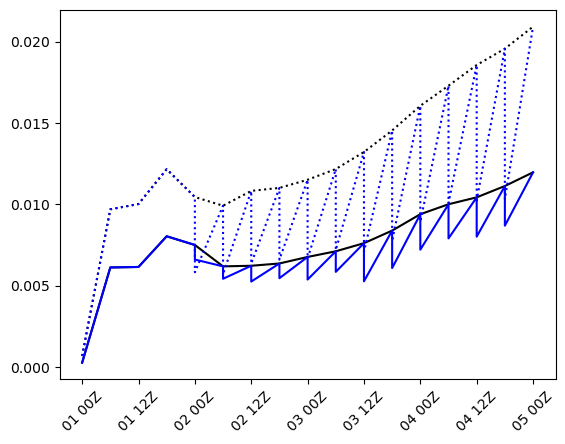

In [39]:
plt.plot(ts, rmse_ts_noda, 'k-', label='NoDA: RMSE')
plt.plot(ts, sprd_ts_noda, 'k:', label='NoDA: spread')
plt.plot(ts, rmse_ts, 'b-', label='DA: RMSE')
plt.plot(ts, sprd_ts, 'b:', label='DA: spread')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %HZ'))
_ = plt.xticks(rotation=45)

## Assimilate single observation

## Cycling DA

In [8]:
##rerun cycling experiment from previous free ens run

def run_analysis():
    c.time = c.time_analysis_start
    while c.time < c.time_end:
        print(f"\n\033[1;33mCURRENT CYCLE\033[0m: {c.time} => {c.next_time}", flush=True)

        # don't need to run scheme.preprocess to link files and perturb again
        # only copy the restart files from previous cycle
        for m in range(c.nens):
            file1 = model.filename(path=c.forecast_dir(c.prev_time, 'nextsim.dg'), member=m, time=c.time) 
            file2 = model.filename(path=c.forecast_dir(c.time, 'nextsim.dg'), member=m, time=c.time)
            os.system(f"cp {file1} {file2}")

        # run data assimilation
        scheme.run_step(c, 'filter', mpi=True)

        # postprocess model variables
        scheme.run_step(c, 'postprocess', mpi=False)

        # ensemble forecast step
        scheme.run_step(c, 'ensemble_forecast', mpi=False)

        # advance to next cycle
        c.time = c.next_time

run_analysis()


CURRENT CYCLE: 2010-01-02 00:00:00+00:00 => 2010-01-02 06:00:00+00:00

RUNNING filter step
Running analysis for outer iteration step 0:
Running assimilation step in /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001020000/analysis/

>>> prepare state by reading fields from model restart
..................................................| 100% done.
>>> compute ensemble mean, save to /home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001020000/analysis/z_coords.bin
..................................................| 100% done.
timer: prepare_state took 0.6124379634857178 seconds
>>> read observation sequence from datasets
number of seaice_conc obs from osisaf.ice_conc: 1000
timer: prepare_obs took 0.4682769775390625 seconds
>>> compute observation priors
..................................................| 100% done.
timer: prepare_obs_from_state took 0.0632021427154541 seconds
>>> compute ensemble mean, save to /home/nextsim-workshop/data-nex

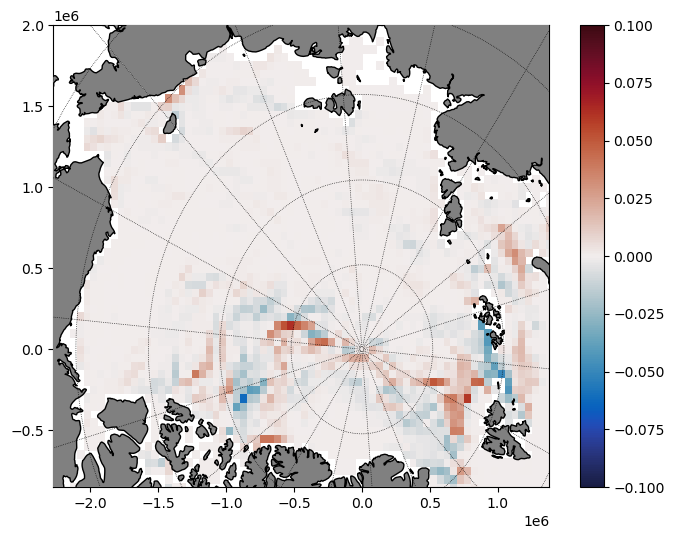

In [32]:
from NEDAS.assim_tools.state import State
state = State(c)

time = c.time_analysis_start

##which field record to show?
varname = 'seaice_conc_dg'
k = 0
rec_id = [i for i,r in state.info['fields'].items() if r['name']==varname and r['k']==k][0]

##which member?
mem_id = 0

path = c.analysis_dir(time)

# read from analysis/*bin files
binfile = os.path.join(path, 'prior_state.bin')
fld0 = state.read_field(binfile, c.grid.mask, mem_id, rec_id)
binfile = os.path.join(path, 'post_state.bin')
fld1 = state.read_field(binfile, c.grid.mask, mem_id, rec_id)

# read from model restart files
#path = c.forecast_dir(c.prev_time, 'nextsim.dg')
#fld0 = model.read_var(path=path, member=mem_id, time=c.time, name=varname, k=k)
#path = c.forecast_dir(c.time, 'nextsim.dg')
#fld1 = model.read_var(path=path, member=mem_id, time=c.time, name=varname, k=k)

fig, ax = plt.subplots(1, 1, figsize=(8,6))

#im = c.grid.plot_field(ax, (fld0)[...], vmin=0, vmax=1, cmap=cmocean.cm.ice)
im = c.grid.plot_field(ax, (fld1-fld0)[...], vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance)
plt.colorbar(im)

##obs network
seq = np.load("/home/nextsim-workshop/data-nextsim-workshop2025/assimilation/cycle/201001020000/analysis/obs_seq.rec0.npy",
              allow_pickle=True).item()
#c.grid.plot_scatter(ax, seq['obs'], x=seq['x'], y=seq['y'], vmin=0, vmax=1, cmap=cmocean.cm.ice, markersize=20)

c.grid.plot_land(ax, color='gray')